# CT-213: Otimização de Hiperparâmetros com Metaheurísticas em Modelos de Classificação Financeira

## Instalação de Dependências e Imports

In [17]:
# Bibliotecas principais para manipulação de dados e machine learning
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e modelos clássicos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score

# Otimização de hiperparâmetros
import optuna

# Utilitário para salvar modelo treinado
import joblib

# Bibliotecas para trabalhar com modelos transformers/bert
from transformers import pipeline, AutoTokenizer, AutoModel
import torch

import os
os.makedirs("figs", exist_ok=True)



## Carregamento e Preparação dos Dados

In [18]:
# Célula 2 — Carregamento do FiQA com HuggingFace Datasets

# Instale se necessário:
# !pip install datasets

from datasets import load_dataset

# Carrega o dataset FiQA (train, valid, test separados)
fiqa = load_dataset("TheFinAI/fiqa-sentiment-classification")

# Vamos juntar treino + validação para aumentar a amostra
df_train = fiqa['train'].to_pandas()
df_valid = fiqa['valid'].to_pandas()
df_test  = fiqa['test'].to_pandas()

df = pd.concat([df_train, df_valid, df_test], ignore_index=True)

# Visualiza as colunas do FiQA
print(df.columns)
print(df.head())


Index(['_id', 'sentence', 'target', 'aspect', 'score', 'type'], dtype='object')
    _id                                           sentence  \
0     1  Royal Mail chairman Donald Brydon set to step ...   
1   100     Slump in Weir leads FTSE down from record high   
2  1000  AstraZeneca wins FDA approval for key new lung...   
3  1002  UPDATE 1-Lloyds to cut 945 jobs as part of 3-y...   
4  1005  Standard Chartered Shifts Emerging-Markets Str...   

               target                        aspect  score      type  
0          Royal Mail         Corporate/Appointment -0.374  headline  
1                Weir  Market/Volatility/Volatility -0.827  headline  
2         AstraZeneca          Corporate/Regulatory  0.549  headline  
3              Lloyds            Corporate/Strategy -0.266  headline  
4  Standard Chartered            Corporate/Strategy -0.461  headline  


## Ajuste/preparação dos rótulos para FiQA

In [19]:
# Mapeando score contínuo para classes categóricas
def map_score_to_sentiment(score):
    if score > 0.33:
        return 'positive'
    elif score < -0.33:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['score'].apply(map_score_to_sentiment)
df['sentence'] = df['sentence'].astype(str)

# Remove linhas sem texto ou rótulo válido
df = df.dropna(subset=['sentence', 'sentiment'])
df = df[df['sentiment'].isin(['positive', 'neutral', 'negative'])]
df = df.reset_index(drop=True)

print(df['sentiment'].value_counts())
print(df.head())


sentiment
positive    471
neutral     462
negative    240
Name: count, dtype: int64
    _id                                           sentence  \
0     1  Royal Mail chairman Donald Brydon set to step ...   
1   100     Slump in Weir leads FTSE down from record high   
2  1000  AstraZeneca wins FDA approval for key new lung...   
3  1002  UPDATE 1-Lloyds to cut 945 jobs as part of 3-y...   
4  1005  Standard Chartered Shifts Emerging-Markets Str...   

               target                        aspect  score      type sentiment  
0          Royal Mail         Corporate/Appointment -0.374  headline  negative  
1                Weir  Market/Volatility/Volatility -0.827  headline  negative  
2         AstraZeneca          Corporate/Regulatory  0.549  headline  positive  
3              Lloyds            Corporate/Strategy -0.266  headline   neutral  
4  Standard Chartered            Corporate/Strategy -0.461  headline  negative  


## Análise exploratória básica

C:\Users\ITA\AppData\Local\Temp\ipykernel_23028\2272850752.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'], palette='viridis')


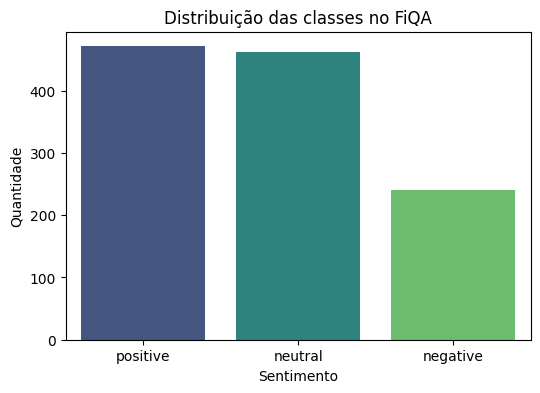


Exemplos de sentenças por classe (FiQA):

--- POSITIVE ---
['Tesco sells half of stake in ecommerce site Lazada to Alibaba for Â£90m'
 'UPDATE 1-Berkshire applies to boost Wells Fargo stake above 10 pct']

--- NEUTRAL ---
['Equity indexes working on a positive engulfing for March. $SML $RUT $IWC $SMH $SOX  Small-caps / semis with a fakeout before the b/out.'
 'Valeant Said to Name New CEO With Pearson Still Hospitalized']

--- NEGATIVE ---
['UPDATE 3-Ex-Barclays director accused by US of illegal tips to plumber'
 'StanChart and RBS struggle in Bank of England stress tests']



In [20]:
# Visualizar distribuição das classes no FiQA
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'], palette='viridis')
plt.title('Distribuição das classes no FiQA')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.savefig("figs/distribuicao_classes_fiqa.png", dpi=1000, bbox_inches='tight')
plt.show()

# Exibir exemplos aleatórios de cada classe
print("\nExemplos de sentenças por classe (FiQA):\n")
for sentiment in ['positive', 'neutral', 'negative']:
    exemplos = df[df['sentiment'] == sentiment]['sentence']
    if len(exemplos) > 0:
        print(f"--- {sentiment.upper()} ---")
        print(exemplos.sample(2, random_state=42).values)
        print()


## Split treino/teste do FiQA e baseline TF-IDF + LogisticRegression

In [21]:
# Separar dados em treino e teste (usaremos o mesmo split para todas as abordagens)
X = df['sentence']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline clássico com parâmetros padrão
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,1))
model = LogisticRegression(max_iter=300)
pipeline_baseline = make_pipeline(vectorizer, model)

# Treinar e avaliar
pipeline_baseline.fit(X_train, y_train)
y_pred_baseline = pipeline_baseline.predict(X_test)

print("Relatório de Classificação - Baseline (TF-IDF + LogisticRegression) no FiQA:\n")
print(classification_report(y_test, y_pred_baseline, zero_division=0))


Relatório de Classificação - Baseline (TF-IDF + LogisticRegression) no FiQA:

              precision    recall  f1-score   support

    negative       0.58      0.23      0.33        48
     neutral       0.56      0.67      0.61        93
    positive       0.62      0.69      0.65        94

    accuracy                           0.59       235
   macro avg       0.59      0.53      0.53       235
weighted avg       0.59      0.59      0.57       235



## Otimização de hiperparâmetros (Optuna) para TF-IDF + LogisticRegression no FiQA

In [22]:
def run_pipeline_with_params(max_features=5000, C=1.0, ngram_range=(1,1), solver='lbfgs'):
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    model = LogisticRegression(C=C, solver=solver, max_iter=300)
    pipeline = make_pipeline(vectorizer, model)
    scores = cross_val_score(
        pipeline, X_train, y_train, cv=3, scoring='f1_macro'
    )
    return np.mean(scores)

def objective(trial):
    max_features = trial.suggest_int('max_features', 1000, 8000)
    C = trial.suggest_loguniform('C', 1e-4, 10.0)
    ngram_low = trial.suggest_int('ngram_low', 1, 2)
    ngram_high = trial.suggest_int('ngram_high', ngram_low, 3)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    ngram_range = (ngram_low, ngram_high)
    try:
        score = run_pipeline_with_params(
            max_features, C, ngram_range, solver
        )
    except Exception as e:
        print(e)
        return 0
    return score

# Rodando a otimização
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Melhores hiperparâmetros encontrados:", study.best_params)
print("Melhor F1-macro médio (validação cruzada):", study.best_value)


[I 2025-07-08 01:27:13,762] A new study created in memory with name: no-name-5a948e3a-f3b6-4d74-a238-320244b9c849
C:\Users\ITA\AppData\Local\Temp\ipykernel_23028\1278927050.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10.0)
c:\Users\ITA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\ITA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-07-08 01:27:14,052] Trial 0 finished with value: 0.19112735124265387 and parameters: {'max_features': 2132, 'C': 0.0005304870909722181, 'ngram_low'

Melhores hiperparâmetros encontrados: {'max_features': 3645, 'C': 8.021158381904545, 'ngram_low': 1, 'ngram_high': 2, 'solver': 'saga'}
Melhor F1-macro médio (validação cruzada): 0.5617343656823987


## Avaliação do Pipeline TF-IDF + LogisticRegression Otimizado

In [23]:
# Recupera os melhores hiperparâmetros
best_params = study.best_params
best_ngram_range = (best_params['ngram_low'], best_params['ngram_high'])

# Monta e treina o pipeline otimizado
vectorizer_opt = TfidfVectorizer(
    max_features=best_params['max_features'],
    ngram_range=best_ngram_range
)
model_opt = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    max_iter=300
)
pipeline_optim = make_pipeline(vectorizer_opt, model_opt)
pipeline_optim.fit(X_train, y_train)

# Faz predições
y_pred_optim = pipeline_optim.predict(X_test)

print("Relatório de Classificação - Pipeline Otimizado (TF-IDF + LogisticRegression) no FiQA:\n")
print(classification_report(y_test, y_pred_optim, zero_division=0))


Relatório de Classificação - Pipeline Otimizado (TF-IDF + LogisticRegression) no FiQA:

              precision    recall  f1-score   support

    negative       0.58      0.44      0.50        48
     neutral       0.56      0.62      0.59        93
    positive       0.65      0.66      0.65        94

    accuracy                           0.60       235
   macro avg       0.60      0.57      0.58       235
weighted avg       0.60      0.60      0.60       235



## Análise gráfica/comparativa do TF-IDF (baseline vs. otimizado)

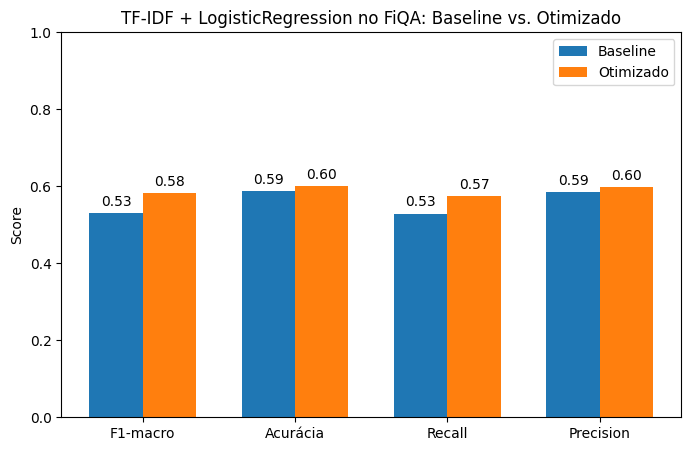

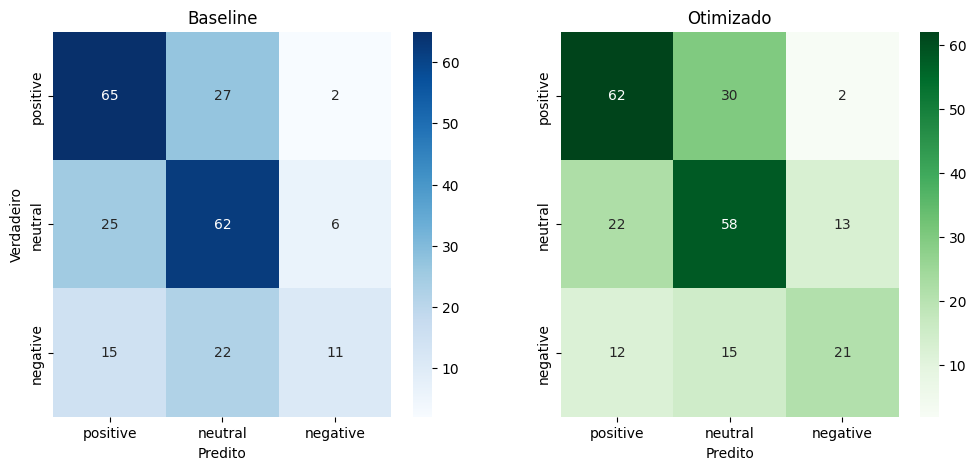

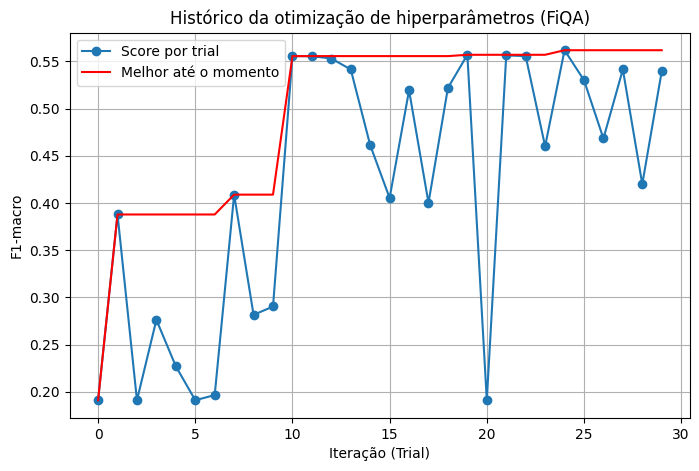

In [24]:
# Métricas agregadas para as duas versões
metrics = ['F1-macro', 'Acurácia', 'Recall', 'Precision']

baseline_scores = [
    f1_score(y_test, y_pred_baseline, average='macro'),
    accuracy_score(y_test, y_pred_baseline),
    recall_score(y_test, y_pred_baseline, average='macro'),
    precision_score(y_test, y_pred_baseline, average='macro')
]

optimized_scores = [
    f1_score(y_test, y_pred_optim, average='macro'),
    accuracy_score(y_test, y_pred_optim),
    recall_score(y_test, y_pred_optim, average='macro'),
    precision_score(y_test, y_pred_optim, average='macro')
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline')
rects2 = ax.bar(x + width/2, optimized_scores, width, label='Otimizado')

ax.set_ylabel('Score')
ax.set_title('TF-IDF + LogisticRegression no FiQA: Baseline vs. Otimizado')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()


for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig("figs/tf-idf_baseline_vs_otimizado_fiqa.png", dpi=300, bbox_inches='tight')
plt.show()

# Matrizes de confusão lado a lado
labels = ['positive', 'neutral', 'negative']
cm_baseline = confusion_matrix(y_test, y_pred_baseline, labels=labels)
cm_optim = confusion_matrix(y_test, y_pred_optim, labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Baseline')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Verdadeiro')
sns.heatmap(cm_optim, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Otimizado')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('')

plt.savefig("figs/matriz_confusao_tf-idf_fiqa.png", dpi=300, bbox_inches='tight')
plt.show()

# Evolução do score no Optuna
scores = [trial.value for trial in study.trials]
best_so_far = np.maximum.accumulate(scores)
plt.figure(figsize=(8,5))
plt.plot(scores, 'o-', label='Score por trial')
plt.plot(best_so_far, 'r-', label='Melhor até o momento')
plt.xlabel('Iteração (Trial)')
plt.ylabel('F1-macro')
plt.title('Histórico da otimização de hiperparâmetros (FiQA)')
plt.legend()
plt.grid()
plt.savefig("figs/evolucao_optuna_tf-idf_fiqa.png", dpi=300, bbox_inches='tight')
plt.show()


## Classificação direta com FinBERT (pipeline HuggingFace)

In [25]:
# Caso ainda não tenha instalado transformers e torch:
# !pip install transformers torch

from transformers import pipeline

# Carrega pipeline do FinBERT (pode demorar no primeiro uso)
finbert_pipe = pipeline("text-classification", model="ProsusAI/finbert")

# Aplica o pipeline diretamente nas frases do conjunto de teste do FiQA
# (isso pode ser demorado dependendo do tamanho do X_test)
y_pred_finbert = []
for sentence in X_test:
    result = finbert_pipe(sentence)[0]['label'].lower()
    # Ajusta para o padrão de rótulos do dataset
    if result == 'positive':
        y_pred_finbert.append('positive')
    elif result == 'negative':
        y_pred_finbert.append('negative')
    else:
        y_pred_finbert.append('neutral')

print("Relatório de Classificação - FinBERT (pipeline direto) no FiQA:\n")
print(classification_report(y_test, y_pred_finbert, zero_division=0))


Device set to use cpu


Relatório de Classificação - FinBERT (pipeline direto) no FiQA:

              precision    recall  f1-score   support

    negative       0.56      0.65      0.60        48
     neutral       0.48      0.59      0.53        93
    positive       0.69      0.48      0.57        94

    accuracy                           0.56       235
   macro avg       0.58      0.57      0.57       235
weighted avg       0.58      0.56      0.56       235



## Análises gráficas: Classificação direta com FinBERT

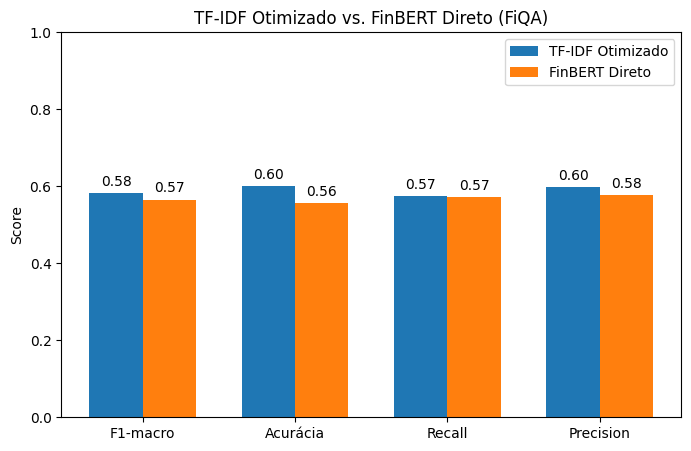

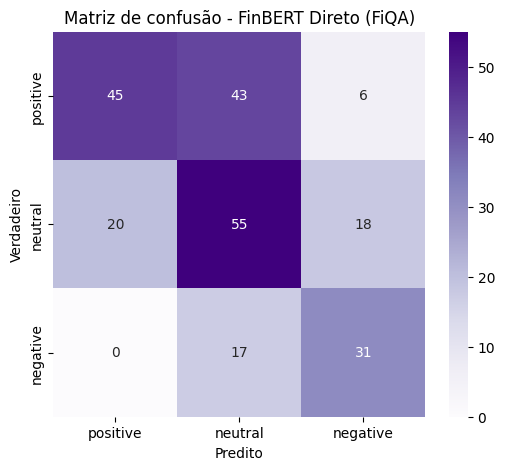

In [26]:
# Métricas do FinBERT direto no FiQA
finbert_scores = [
    f1_score(y_test, y_pred_finbert, average='macro'),
    accuracy_score(y_test, y_pred_finbert),
    recall_score(y_test, y_pred_finbert, average='macro'),
    precision_score(y_test, y_pred_finbert, average='macro')
]

# Comparação (TF-IDF otimizado vs. FinBERT direto) no FiQA
metrics = ['F1-macro', 'Acurácia', 'Recall', 'Precision']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, optimized_scores, width, label='TF-IDF Otimizado')
rects2 = ax.bar(x + width/2, finbert_scores, width, label='FinBERT Direto')

ax.set_ylabel('Score')
ax.set_title('TF-IDF Otimizado vs. FinBERT Direto (FiQA)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig("figs/finbert_direto_vs_tfidf_otimizado_fiqa.png", dpi=300, bbox_inches='tight')
plt.show()

# Matriz de confusão para o FinBERT direto no FiQA
labels = ['positive', 'neutral', 'negative']
cm_finbert = confusion_matrix(y_test, y_pred_finbert, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm_finbert, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de confusão - FinBERT Direto (FiQA)')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.savefig("figs/matriz_confusao_finbert_direto_fiqa.png", dpi=300, bbox_inches='tight')
plt.show()


## Extração de embeddings do FinBERT para treino/teste

In [27]:
from transformers import AutoTokenizer, AutoModel
import torch

# Carregar tokenizer e modelo do FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModel.from_pretrained("ProsusAI/finbert")

def get_finbert_embedding(text, tokenizer, model, device='cpu'):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        # Usa o embedding do [CLS] token
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

# (Opcional: use GPU se disponível)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Gera embeddings para treino
print("Extraindo embeddings do FinBERT (treino)...")
X_train_embeddings = np.array([get_finbert_embedding(s, tokenizer, model, device) for s in X_train])

# Gera embeddings para teste
print("Extraindo embeddings do FinBERT (teste)...")
X_test_embeddings = np.array([get_finbert_embedding(s, tokenizer, model, device) for s in X_test])


Extraindo embeddings do FinBERT (treino)...
Extraindo embeddings do FinBERT (teste)...


## Classificador tradicional (baseline) sobre os embeddings do FinBERT

In [28]:
from sklearn.linear_model import LogisticRegression

# Treina um classificador tradicional (LogisticRegression) com parâmetros padrão nos embeddings
clf_emb_baseline = LogisticRegression(max_iter=300)
clf_emb_baseline.fit(X_train_embeddings, y_train)

# Faz predições no conjunto de teste
y_pred_emb_baseline = clf_emb_baseline.predict(X_test_embeddings)

print("Relatório de Classificação - Embeddings FinBERT + LogisticRegression (baseline) no FiQA:\n")
print(classification_report(y_test, y_pred_emb_baseline, zero_division=0))


Relatório de Classificação - Embeddings FinBERT + LogisticRegression (baseline) no FiQA:

              precision    recall  f1-score   support

    negative       0.65      0.62      0.64        48
     neutral       0.56      0.58      0.57        93
    positive       0.65      0.64      0.64        94

    accuracy                           0.61       235
   macro avg       0.62      0.61      0.62       235
weighted avg       0.61      0.61      0.61       235



c:\Users\ITA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Otimização dos hiperparâmetros do classificador (LogisticRegression) sobre os embeddings do FinBERT com Optuna

In [29]:
def run_emb_classifier_with_params(C=1.0, solver='lbfgs'):
    clf = LogisticRegression(C=C, solver=solver, max_iter=300)
    scores = cross_val_score(
        clf, X_train_embeddings, y_train, cv=3, scoring='f1_macro'
    )
    return np.mean(scores)

def objective_emb(trial):
    C = trial.suggest_loguniform('C', 1e-4, 10.0)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    try:
        score = run_emb_classifier_with_params(C, solver)
    except Exception as e:
        print(e)
        return 0
    return score

study_emb = optuna.create_study(direction='maximize')
study_emb.optimize(objective_emb, n_trials=30)

print("Melhores hiperparâmetros encontrados (embeddings):", study_emb.best_params)
print("Melhor F1-macro médio (validação cruzada, embeddings):", study_emb.best_value)


[I 2025-07-08 01:29:52,701] A new study created in memory with name: no-name-7c617c98-8317-42c9-b17b-efbf0efb375a
C:\Users\ITA\AppData\Local\Temp\ipykernel_23028\2353785708.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10.0)
[I 2025-07-08 01:29:53,276] Trial 0 finished with value: 0.5968419659407331 and parameters: {'C': 0.0005811294744348497, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5968419659407331.
C:\Users\ITA\AppData\Local\Temp\ipykernel_23028\2353785708.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10.0)
c:\Users\ITA\AppData\Local\Programs\Python\Python311\Lib\site

Melhores hiperparâmetros encontrados (embeddings): {'C': 0.012650106319154718, 'solver': 'lbfgs'}
Melhor F1-macro médio (validação cruzada, embeddings): 0.6219588001830813


## Avaliação do classificador otimizado nos embeddings do FinBERT

In [30]:
# Recupera os melhores hiperparâmetros encontrados pela busca
best_params_emb = study_emb.best_params

# Monta e treina o classificador otimizado
clf_emb_optim = LogisticRegression(
    C=best_params_emb['C'],
    solver=best_params_emb['solver'],
    max_iter=300
)
clf_emb_optim.fit(X_train_embeddings, y_train)

# Faz predições no conjunto de teste
y_pred_emb_optim = clf_emb_optim.predict(X_test_embeddings)

print("Relatório de Classificação - Embeddings FinBERT + LogisticRegression (otimizado) no FiQA:\n")
print(classification_report(y_test, y_pred_emb_optim, zero_division=0))


Relatório de Classificação - Embeddings FinBERT + LogisticRegression (otimizado) no FiQA:

              precision    recall  f1-score   support

    negative       0.68      0.58      0.63        48
     neutral       0.62      0.66      0.64        93
    positive       0.73      0.74      0.74        94

    accuracy                           0.68       235
   macro avg       0.68      0.66      0.67       235
weighted avg       0.68      0.68      0.68       235



## Análises gráficas: Embeddings FinBERT + LogisticRegression (baseline vs. otimizado)

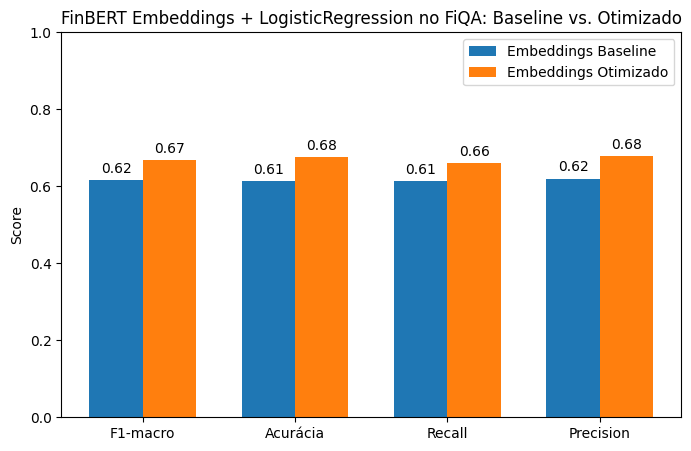

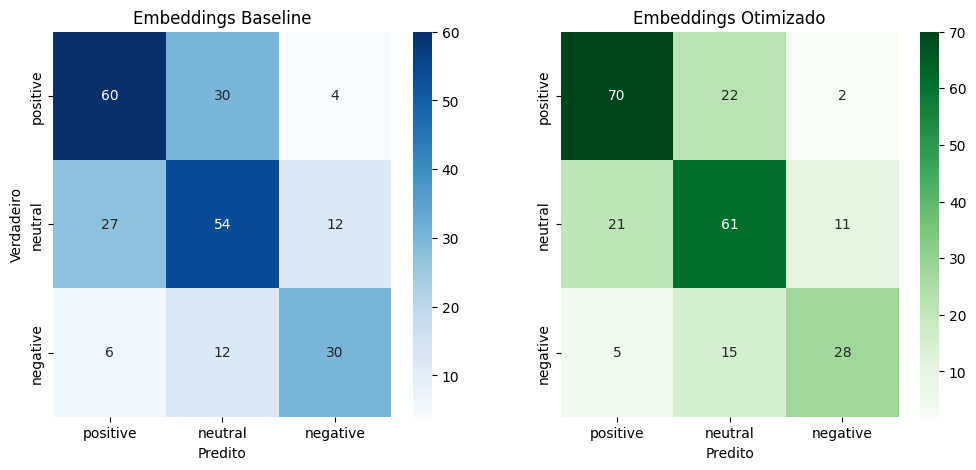

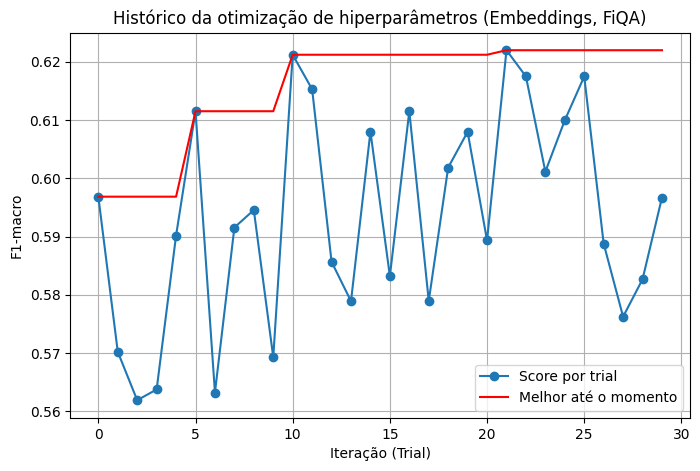

In [31]:
# Métricas para embeddings (baseline e otimizado) no FiQA
emb_baseline_scores = [
    f1_score(y_test, y_pred_emb_baseline, average='macro'),
    accuracy_score(y_test, y_pred_emb_baseline),
    recall_score(y_test, y_pred_emb_baseline, average='macro'),
    precision_score(y_test, y_pred_emb_baseline, average='macro')
]

emb_optimized_scores = [
    f1_score(y_test, y_pred_emb_optim, average='macro'),
    accuracy_score(y_test, y_pred_emb_optim),
    recall_score(y_test, y_pred_emb_optim, average='macro'),
    precision_score(y_test, y_pred_emb_optim, average='macro')
]

metrics = ['F1-macro', 'Acurácia', 'Recall', 'Precision']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, emb_baseline_scores, width, label='Embeddings Baseline')
rects2 = ax.bar(x + width/2, emb_optimized_scores, width, label='Embeddings Otimizado')

ax.set_ylabel('Score')
ax.set_title('FinBERT Embeddings + LogisticRegression no FiQA: Baseline vs. Otimizado')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')
plt.savefig("figs/embeddings_baseline_vs_otimizado_fiqa.png", dpi=300, bbox_inches='tight')
plt.show()

# Matrizes de confusão
labels = ['positive', 'neutral', 'negative']
cm_emb_baseline = confusion_matrix(y_test, y_pred_emb_baseline, labels=labels)
cm_emb_optim = confusion_matrix(y_test, y_pred_emb_optim, labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_emb_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Embeddings Baseline')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Verdadeiro')
sns.heatmap(cm_emb_optim, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Embeddings Otimizado')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('')
plt.savefig("figs/matriz_confusao_embeddings_fiqa.png", dpi=300, bbox_inches='tight')
plt.show()

# Evolução do score no Optuna para embeddings no FiQA
scores_emb = [trial.value for trial in study_emb.trials]
best_so_far_emb = np.maximum.accumulate(scores_emb)
plt.figure(figsize=(8,5))
plt.plot(scores_emb, 'o-', label='Score por trial')
plt.plot(best_so_far_emb, 'r-', label='Melhor até o momento')
plt.xlabel('Iteração (Trial)')
plt.ylabel('F1-macro')
plt.title('Histórico da otimização de hiperparâmetros (Embeddings, FiQA)')
plt.legend()
plt.grid()
plt.savefig("figs/evolucao_optuna_embeddings_fiqa.png", dpi=300, bbox_inches='tight')
plt.show()


## Comparação final entre todas as abordagens

Resumo comparativo das principais métricas (FiQA):

                      Abordagem  F1-macro  Acurácia
0               TF-IDF Baseline  0.529823  0.587234
1              TF-IDF Otimizado  0.581489  0.600000
2                FinBERT Direto  0.565609  0.557447
3   Embeddings FinBERT Baseline  0.617146  0.612766
4  Embeddings FinBERT Otimizado  0.668266  0.676596


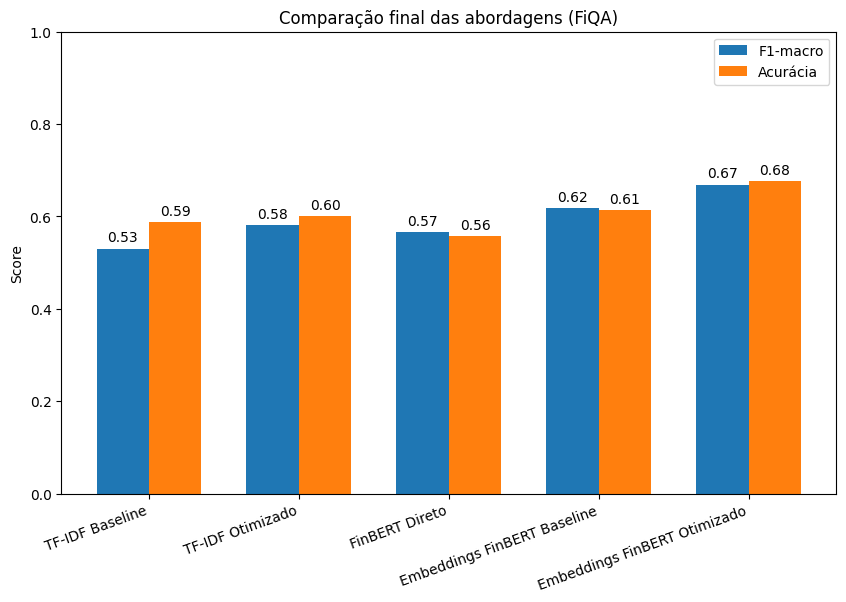

In [32]:
# Coleta de métricas principais (F1-macro e acurácia) de cada abordagem no FiQA
results_df = pd.DataFrame({
    'Abordagem': [
        'TF-IDF Baseline',
        'TF-IDF Otimizado',
        'FinBERT Direto',
        'Embeddings FinBERT Baseline',
        'Embeddings FinBERT Otimizado'
    ],
    'F1-macro': [
        f1_score(y_test, y_pred_baseline, average='macro'),
        f1_score(y_test, y_pred_optim, average='macro'),
        f1_score(y_test, y_pred_finbert, average='macro'),
        f1_score(y_test, y_pred_emb_baseline, average='macro'),
        f1_score(y_test, y_pred_emb_optim, average='macro')
    ],
    'Acurácia': [
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred_optim),
        accuracy_score(y_test, y_pred_finbert),
        accuracy_score(y_test, y_pred_emb_baseline),
        accuracy_score(y_test, y_pred_emb_optim)
    ]
})

print("Resumo comparativo das principais métricas (FiQA):\n")
print(results_df)

# Gráfico de barras para F1-macro e acurácia no FiQA
x = np.arange(len(results_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, results_df['F1-macro'], width, label='F1-macro')
rects2 = ax.bar(x + width/2, results_df['Acurácia'], width, label='Acurácia')

ax.set_ylabel('Score')
ax.set_title('Comparação final das abordagens (FiQA)')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Abordagem'], rotation=20, ha='right')
ax.set_ylim(0, 1)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig("figs/comparacao_final_abordagens_fiqa.png", dpi=300, bbox_inches='tight')
plt.show()


## Manual rápido de execução e dependências

## Manual rápido de execução

1. **Pré-requisitos:**  
   Certifique-se de ter os seguintes pacotes instalados (use pip conforme necessário):
```
pip install pandas numpy scikit-learn matplotlib seaborn joblib optuna torch transformers datasets
```


2. **Download automático do FiQA:**  
O dataset FiQA será baixado automaticamente pelas bibliotecas Hugging Face (`datasets`). Não precisa baixar manualmente.

3. **Execução:**  
- Execute as células do notebook na ordem apresentada.
- A extração de embeddings do FinBERT pode demorar alguns minutos (use GPU se possível).
- Se estiver usando Google Colab, ative a GPU em:  
  `Ambiente de execução > Alterar tipo de hardware > GPU`.

4. **Saídas:**  
- Relatórios de classificação, matrizes de confusão e gráficos para cada abordagem.
- Gráficos de evolução da otimização de hiperparâmetros.
- Comparação final de desempenho entre as abordagens.

5. **Salvando modelos:**  
Para salvar um pipeline ou classificador treinado:
```python
import joblib
joblib.dump(seu_modelo, 'nome_do_modelo.pkl')
```

6. **Reprodutibilidade:**
Todos os splits usam random_state=42 para garantir reprodutibilidade dos resultados.
